In [63]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from imageai.Detection import ObjectDetection
from IPython.display import clear_output
from sklearn import preprocessing
import pickle
from mpl_toolkits.axes_grid1 import Grid

# example of converting an image with the Keras API
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model

In [2]:
%run paths.py # Load all our paths
%run methods.py # Load all our methods

detector_name = "yolo"
DETECTIONS_FILE = os.path.join(DETECTIONS_DIR , detector_name+"-detections.csv")

os.listdir(DATASET_DIR)

['test_images',
 'train_masks.zip',
 'train_images.zip',
 'car_models',
 '.ipynb_checkpoints',
 'car_models_json.zip',
 'car_models.zip',
 'test_masks',
 'train.csv',
 'train_images',
 'test_images.zip',
 'train_masks',
 'camera.zip',
 'sample_submission.csv',
 'car_models_json',
 'test_masks.zip',
 'camera']

In [3]:
df_detections = pd.read_csv(DETECTIONS_FILE)
df_detections.drop_duplicates(keep = "first", inplace = True)
df_detections.to_csv(DETECTIONS_FILE)
display(df_detections)

Unnamed: 0         ImageId  Probability      x1      x2      y1  \
0               0  ID_8a6e65317-1    64.780223  1949.0  2172.0  1740.0   
1               1  ID_8a6e65317-2    98.063952  2522.0  3050.0  1807.0   
2               2  ID_8a6e65317-3    98.919398  2873.0  3384.0  1839.0   
3               3  ID_8a6e65317-4    99.524534   607.0   941.0  1727.0   
4               8  ID_337ddc495-1    65.653896  1303.0  1397.0  1754.0   
...           ...             ...          ...     ...     ...     ...   
26233    55907344  ID_29454123f-4    95.940858  1391.0  1523.0  1762.0   
26234    55907345  ID_29454123f-5    98.031765  1824.0  1932.0  1773.0   
26235    55907346  ID_29454123f-6    99.310279  2268.0  2631.0  1828.0   
26236    55933583  ID_2dee4d6e6-2    76.999432   584.0   820.0  1710.0   
26237    55933584  ID_2dee4d6e6-3    78.237200   772.0   949.0  1691.0   

           y2    id       yaw     pitch     roll         x         y        z  
0      1847.0  70.0  0.163072 -1.568650 -3.11754  10.39000  11.22190  59.7825  
1      2039.0  56.0  0.181647 -1.469470 -3.12159   9.60332   4.66632  19.3390  
2      2147.0  16.0  0.254839 -2.575340 -3.10256   7.96539   3.20066  11.0225  
3      1929.0  70.0  0.141942 -3.139500  3.11969  -9.59236   5.13662  24.7337  
4      1831.0  28.0  0.186114  0.357280 -3.10043  -7.49818  10.31120  54.0320  
...       ...   ...       ...       ...      ...       ...       ...      ...  
26233  1871.0  16.0  0.147919  0.020073 -3.08263  -3.45690   7.07672  35.6404  
26234  1863.0  16.0  0.147919  0.028850 -3.08263   3.13519   8.09887  40.2738  
26235  2028.0  35.0  0.164734  0.051550 -3.08874   6.99000   5.46318  21.7902  
26236  1826.0  35.0  0.166939  3.080810 -3.11637 -14.88920   6.55844  35.4492  
26237  1763.0  35.0  0.155662  3.129860  3.11924 -20.43220  10.04070  59.2621  

[26238 rows x 14 columns]

In [4]:
"""imgSizes = []

for index,row in df_detections.iterrows():
    
    ImageIdSubId = row["ImageId"]
    ImageIdSubIdList = ImageIdSubId.split("-")
    ImageId = ImageIdSubIdList[0]
    SubId = ImageIdSubIdList[1]
    imagePath = os.path.join(DATASET_DIR , "detections/"+detector_name+"/"+ImageId+".jpg-objects/car-"+SubId+".jpg")
    
    img = open_image(imagePath)
    dimensions = img.shape
    heightImage, widthImage, channels = dimensions
    
    imgSizes.append(heightImage)
    
    clear_output(wait=True)
    print(f"{index+1} Images Analysed. So far, Minimum: {min(imgSizes)}, Maximum: {max(imgSizes)}")
    
    #visualize_image(imagePath,width=5,title=ImageIdSubId)
    
    break"""

#335504 Images Analysed. So far, Minimum: 45, Maximum: 1190
pass

In [5]:
#df_temp = df_detections.head(10000)
#df_temp = df_detections.sample(1000000)
df_temp = df_detections.copy() # Take Whole Dataset

totalDetectionsRows = len(df_temp.index)

train_x = []
train_y = []

countedDetectionRows = 0

for index,row in df_temp.iterrows():
    
    countedDetectionRows +=1
    
    ImageIdSubId = row["ImageId"]
    ImageIdSubIdList = ImageIdSubId.split("-")
    ImageId = ImageIdSubIdList[0]
    SubId = ImageIdSubIdList[1]
    imagePath = os.path.join(DETECTIONS_DIR , detector_name+"/"+ImageId+".jpg-objects/car-"+SubId+".jpg")
    #df_temp.loc[index,"filename"] = imagePath 
    
    inputs_extra = np.array([row["x1"],row["y1"],row["x2"],row["y2"]], dtype="float32").reshape(4,-1)    
    min_max_scaler = preprocessing.MinMaxScaler()
    inputs_extra_scaled = min_max_scaler.fit_transform(inputs_extra)
    inputs_extra_scaled = inputs_extra_scaled.reshape(1,-1)
    
    temp_array = img_to_array(open_image(imagePath,square_size=(48,48)))/255.0
    inputs_extra_weighted = np.full((48*12,4),np.array(inputs_extra_scaled))
    temp_array = np.append(temp_array,inputs_extra_weighted).reshape(48,48,-1)    
    
    train_x.append( temp_array )
    train_y.append([row["x"],row["y"],row["z"],row["yaw"],row["pitch"],row["roll"]])
    
    if(countedDetectionRows%2)==0:
        clear_output(wait=True)
        print(f"{countedDetectionRows}/{totalDetectionsRows} Completed. Just tested ImageID-SubID: {ImageIdSubId}")
    
train_x = np.array(train_x)
train_y = np.array(train_y)
df_temp

26238/26238 Completed. Just tested ImageID-SubID: ID_2dee4d6e6-3


Unnamed: 0         ImageId  Probability      x1      x2      y1  \
0               0  ID_8a6e65317-1    64.780223  1949.0  2172.0  1740.0   
1               1  ID_8a6e65317-2    98.063952  2522.0  3050.0  1807.0   
2               2  ID_8a6e65317-3    98.919398  2873.0  3384.0  1839.0   
3               3  ID_8a6e65317-4    99.524534   607.0   941.0  1727.0   
4               8  ID_337ddc495-1    65.653896  1303.0  1397.0  1754.0   
...           ...             ...          ...     ...     ...     ...   
26233    55907344  ID_29454123f-4    95.940858  1391.0  1523.0  1762.0   
26234    55907345  ID_29454123f-5    98.031765  1824.0  1932.0  1773.0   
26235    55907346  ID_29454123f-6    99.310279  2268.0  2631.0  1828.0   
26236    55933583  ID_2dee4d6e6-2    76.999432   584.0   820.0  1710.0   
26237    55933584  ID_2dee4d6e6-3    78.237200   772.0   949.0  1691.0   

           y2    id       yaw     pitch     roll         x         y        z  
0      1847.0  70.0  0.163072 -1.568650 -3.11754  10.39000  11.22190  59.7825  
1      2039.0  56.0  0.181647 -1.469470 -3.12159   9.60332   4.66632  19.3390  
2      2147.0  16.0  0.254839 -2.575340 -3.10256   7.96539   3.20066  11.0225  
3      1929.0  70.0  0.141942 -3.139500  3.11969  -9.59236   5.13662  24.7337  
4      1831.0  28.0  0.186114  0.357280 -3.10043  -7.49818  10.31120  54.0320  
...       ...   ...       ...       ...      ...       ...       ...      ...  
26233  1871.0  16.0  0.147919  0.020073 -3.08263  -3.45690   7.07672  35.6404  
26234  1863.0  16.0  0.147919  0.028850 -3.08263   3.13519   8.09887  40.2738  
26235  2028.0  35.0  0.164734  0.051550 -3.08874   6.99000   5.46318  21.7902  
26236  1826.0  35.0  0.166939  3.080810 -3.11637 -14.88920   6.55844  35.4492  
26237  1763.0  35.0  0.155662  3.129860  3.11924 -20.43220  10.04070  59.2621  

[26238 rows x 14 columns]

In [6]:
"""
>>> np.savez_compressed('/tmp/123', a=test_array, b=test_vector)
>>> loaded = np.load('/tmp/123.npz')
>>> print(np.array_equal(test_array, loaded['a']))
True
"""
compressedFilename = os.path.join(DETECTIONS_DIR , f"training-set-{countedDetectionRows}.npz")
np.savez_compressed(compressedFilename, x=train_x, y=train_y) # Comment to avoid unintended save
print(f"Compressed File saved at {compressedFilename}")

Compressed File saved at ../detections/training-set-26238.npz


In [7]:
# Loads in less than 5 mins
train = np.load(compressedFilename)
train_x = train['x']
train_y = train['y']
print(f"Compressed File Loaded. train_x shape: {train_x.shape}")

Compressed File Loaded. train_x shape: (26238, 48, 48, 4)


In [8]:
IMG_HEIGHT, IMG_WIDTH = 48,48
INPUT_SHAPE = train_x.shape[1:]
print(INPUT_SHAPE)

"""train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data

train_data_gen = train_image_generator.flow_from_dataframe(dataframe=df_temp,
                                                           x_col='filename',
                                                           y_col=["x","y","z","yaw","pitch","roll"],                                                           
                                                           #y_col="roll",                                                           
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='raw')"""

pass

(48, 48, 4)


In [9]:
def return_cnn_model(input_shape=INPUT_SHAPE, cnn_layers=2, mlp_layers=1, cnn_act='relu', mlp_act='linear'):

    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation=cnn_act, input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    
    for i in range(cnn_layers):
        model.add(layers.Conv2D(64, (3, 3), activation=cnn_act))
        model.add(layers.MaxPooling2D((2, 2)))
        
    #model.add(layers.Conv2D(64, (3, 3), activation='relu'))

    model.add(layers.Flatten())
    
    for i in range(mlp_layers):
        model.add(layers.Dense(6, activation=mlp_act))
    
    model.add(layers.Dense(6))

    # model.summary()
    plot_model(model, to_file=f"analysis/model_cnn-{cnn_layers}-{cnn_act}_mlp-{mlp_layers}-{mlp_act}.png", show_shapes=True, show_layer_names=False)
    
    return model

Running cnn-1-relu_mlp-1-relu_epoch-10
Running cnn-1-relu_mlp-1-linear_epoch-10
Running cnn-1-relu_mlp-1-sigmoid_epoch-10
Running cnn-1-linear_mlp-1-relu_epoch-10
Running cnn-1-linear_mlp-1-linear_epoch-10
Running cnn-1-linear_mlp-1-sigmoid_epoch-10
Running cnn-1-sigmoid_mlp-1-relu_epoch-10
Running cnn-1-sigmoid_mlp-1-linear_epoch-10
Running cnn-1-sigmoid_mlp-1-sigmoid_epoch-10
Running cnn-1-relu_mlp-2-relu_epoch-10
Running cnn-1-relu_mlp-2-linear_epoch-10
Running cnn-1-relu_mlp-2-sigmoid_epoch-10
Running cnn-1-linear_mlp-2-relu_epoch-10
Running cnn-1-linear_mlp-2-linear_epoch-10
Running cnn-1-linear_mlp-2-sigmoid_epoch-10
Running cnn-1-sigmoid_mlp-2-relu_epoch-10
Running cnn-1-sigmoid_mlp-2-linear_epoch-10
Running cnn-1-sigmoid_mlp-2-sigmoid_epoch-10
Running cnn-1-relu_mlp-3-relu_epoch-10
Running cnn-1-relu_mlp-3-linear_epoch-10
Running cnn-1-relu_mlp-3-sigmoid_epoch-10
Running cnn-1-linear_mlp-3-relu_epoch-10
Running cnn-1-linear_mlp-3-linear_epoch-10
Running cnn-1-linear_mlp-3-sigmo

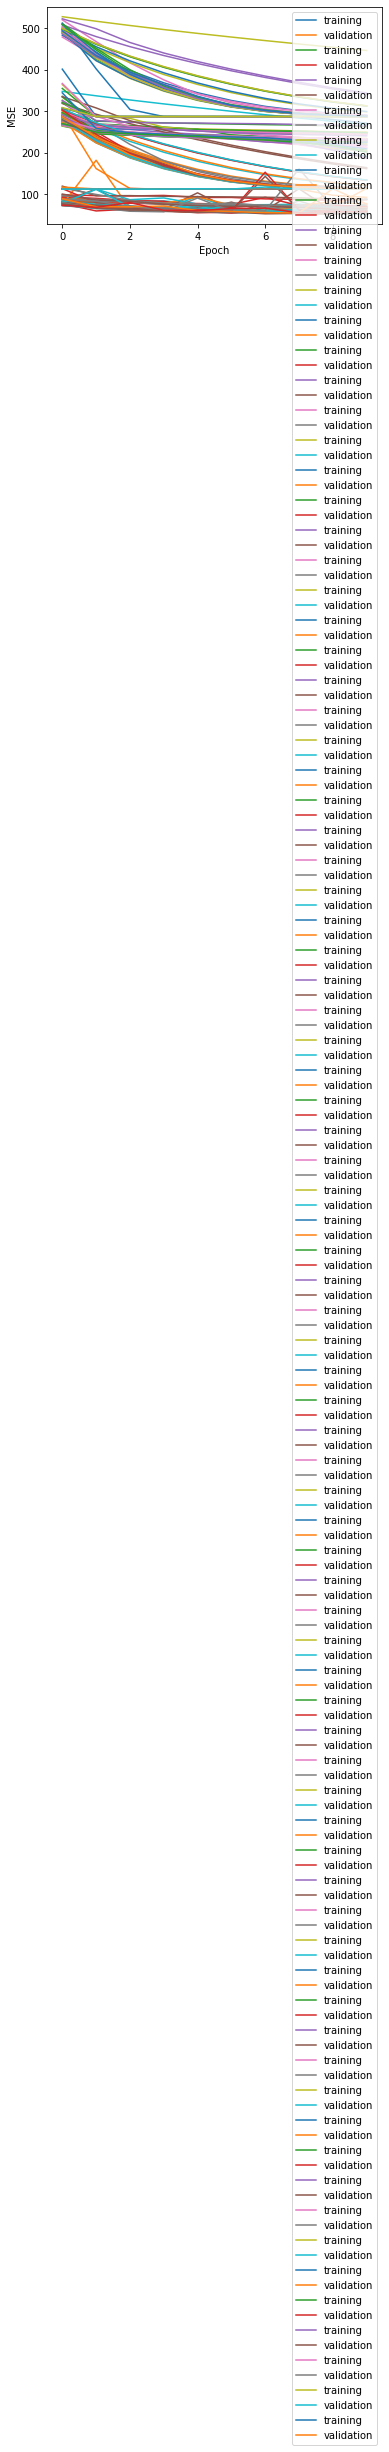

In [13]:
epochs = 10
history = {}

for cnn_layers in range(1,4):
    for mlp_layers in range(1,4):
        for cnn_act in ['relu','linear','sigmoid']:
            for mlp_act in ['relu','linear','sigmoid']:

                model = return_cnn_model(cnn_layers=cnn_layers, mlp_layers=mlp_layers, cnn_act=cnn_act, mlp_act=mlp_act)
                model.compile(optimizer='adam',
                              loss='mean_squared_error',
                              metrics=['mse','accuracy','mean_absolute_percentage_error','mean_absolute_error'])
                
                ID = f"cnn-{cnn_layers}-{cnn_act}_mlp-{mlp_layers}-{mlp_act}_epoch-{epochs}"
                
                print(f"Running {ID}")
                
                history[ID] = model.fit(x=train_x,y=train_y,epochs=epochs,
                                        use_multiprocessing=True,
                                        verbose=0,validation_split=0.1)

                plt.plot(history[ID].history['mean_squared_error'], label='training')
                plt.plot(history[ID].history['val_mean_squared_error'], label='validation')
                plt.xlabel('Epoch')
                plt.ylabel('MSE')
                plt.legend(loc='upper right')

                model.save(os.path.join(MODELS_DIR, f'model_{ID}.h5'))

In [59]:
def save_history(history,historyFilename):
    historySave = dict()
    for i,his in history.items():
        historySave[i] = his.history
    with open(historyFilename, 'wb') as handle:
    pickle.dump(historySave, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [60]:
historyFilename = f"history/history-{epochs}.pickle"
save_history(history,historyFilename)

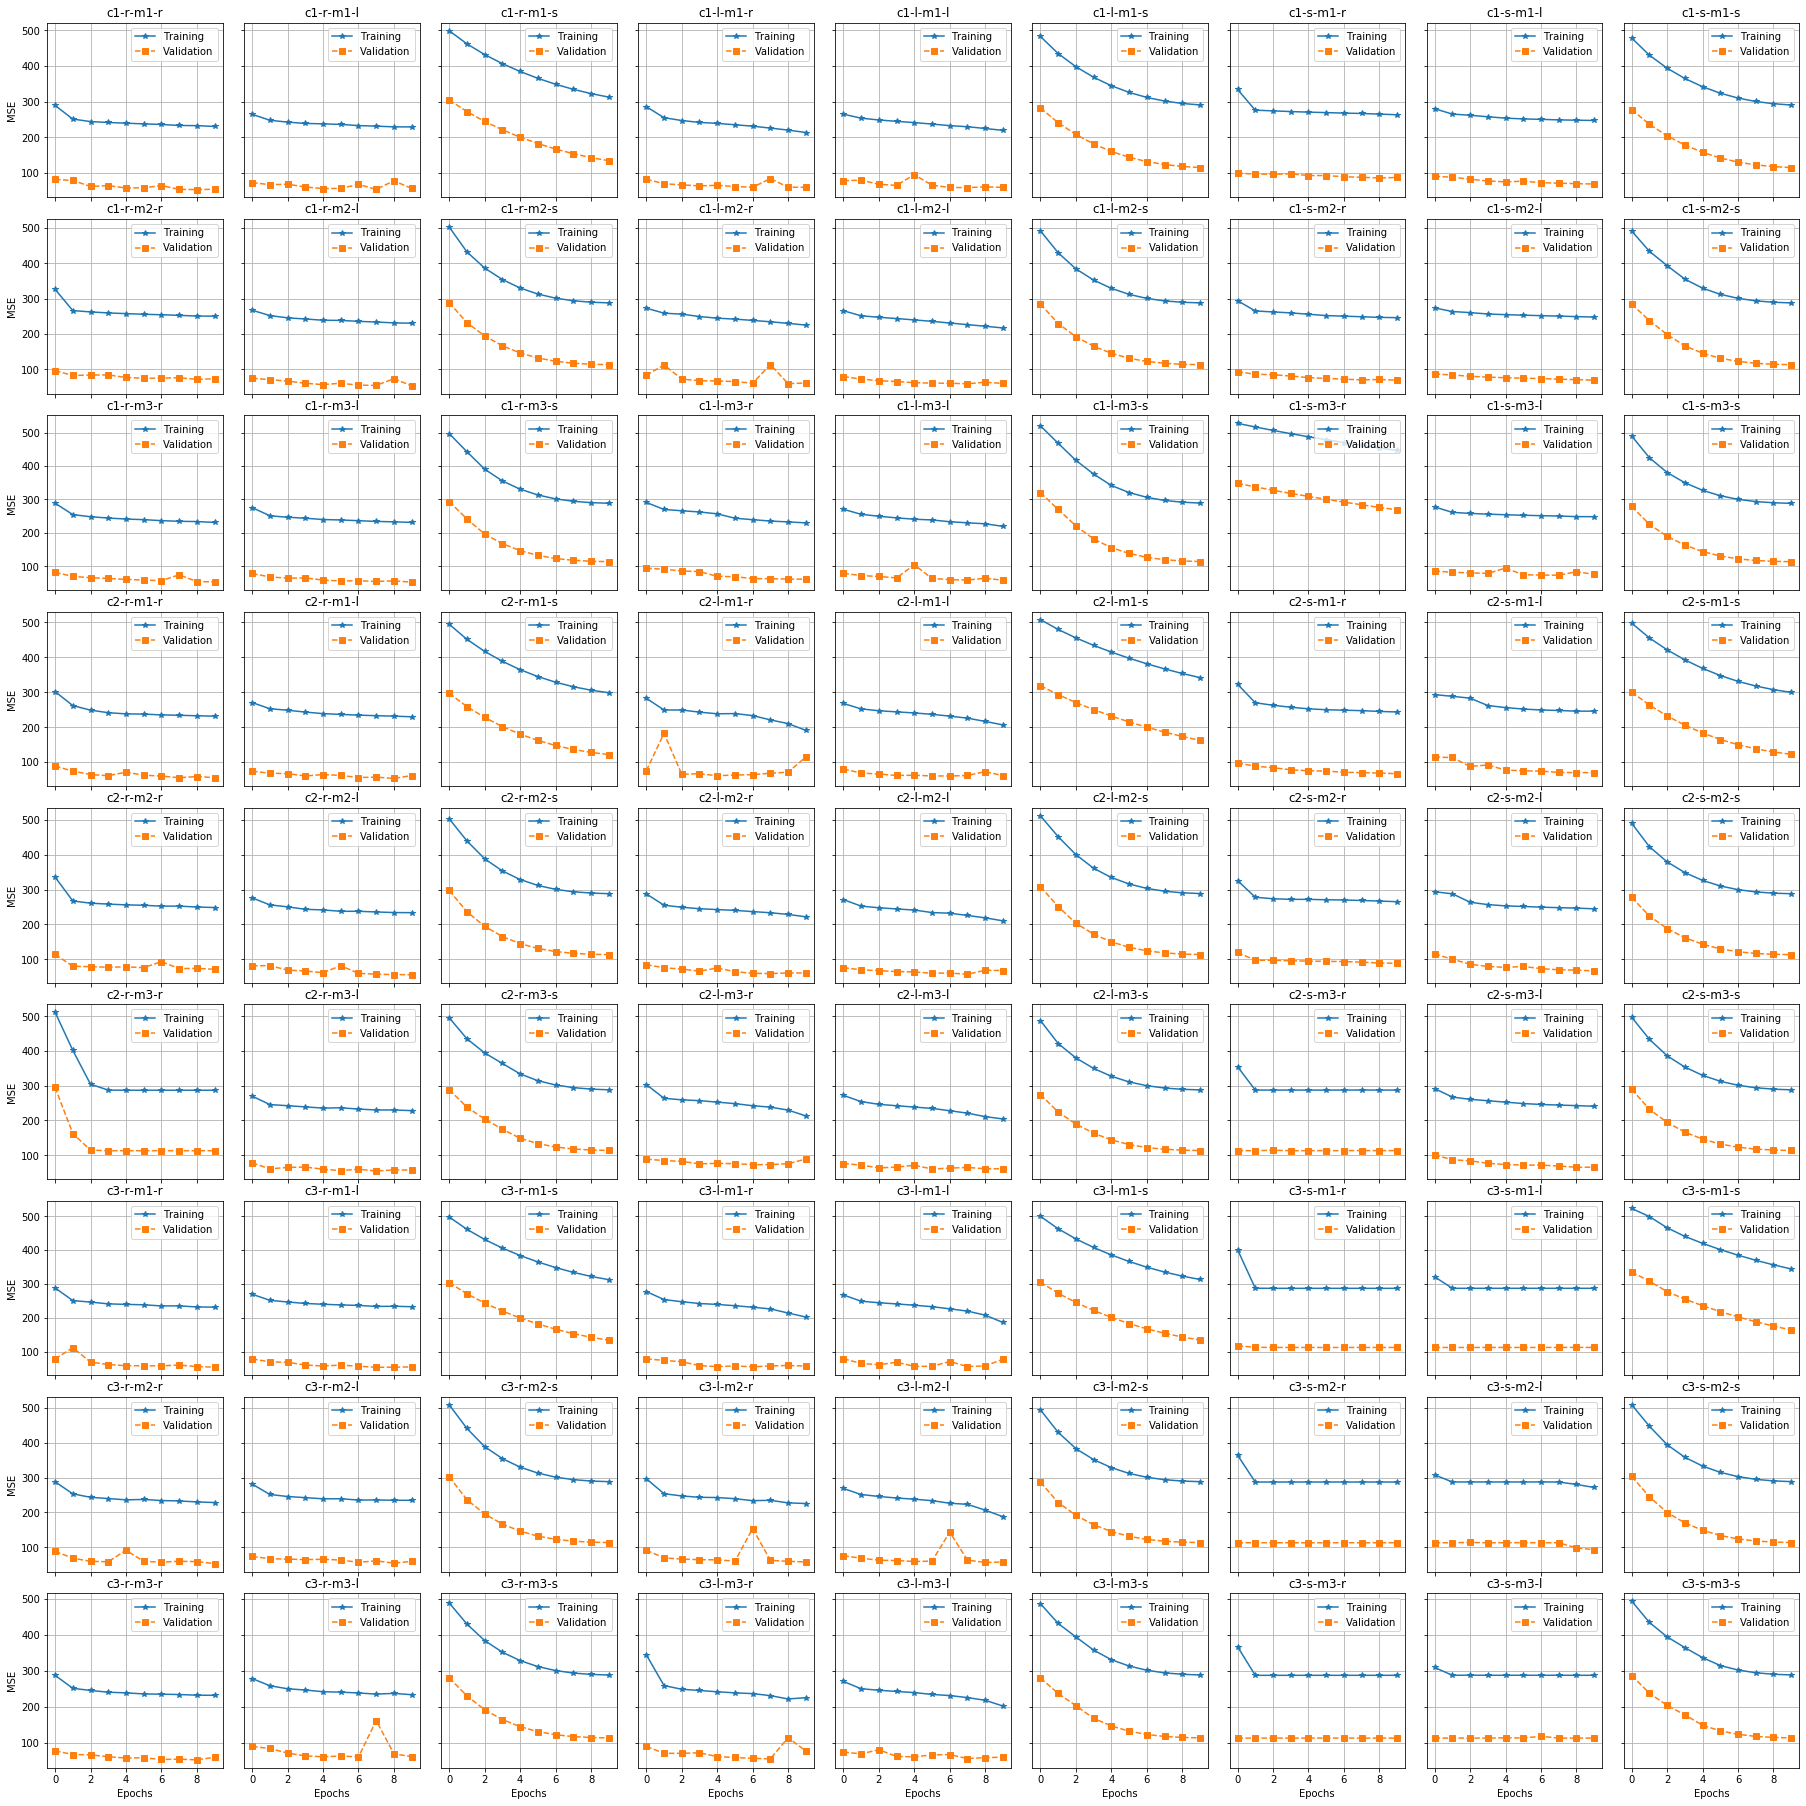

In [62]:
with open(historyFilename, 'rb') as handle:
    history = pickle.load(handle)

linestyles = ['-','--','-.',':']
markerstyles = ['*','s','v','o','<','p','^','.','>']


plt.close('all')
fig = plt.figure()
fig.set_figheight(25)
fig.set_figwidth(25)
grid = Grid(fig, rect=111, nrows_ncols=(9, 9), axes_pad=0.3, label_mode='L',)

gridCount = 0

for cnn_layers in range(1,4):
    for mlp_layers in range(1,4):
        for cnn_act in ['relu','linear','sigmoid']:
            for mlp_act in ['relu','linear','sigmoid']:
                
                ID = f"cnn-{cnn_layers}-{cnn_act}_mlp-{mlp_layers}-{mlp_act}_epoch-{epochs}"
                IDmini = f"c{cnn_layers}-{cnn_act[0]}-m{mlp_layers}-{mlp_act[0]}"
                
                #fig, ax = plt.subplots()
                ax = grid[gridCount]
                gridCount += 1
                
                count = 0

                ax.plot(history[ID]['mean_squared_error'], 
                            label="Training", 
                            linestyle=linestyles[count%len(linestyles)], 
                            marker=markerstyles[count%len(markerstyles)])
                    
                count+=1

                ax.plot(history[ID]['val_mean_squared_error'], 
                        label="Validation", 
                        linestyle=linestyles[count%len(linestyles)], 
                        marker=markerstyles[count%len(markerstyles)])
                    
                    
                ax.set(xlabel='Epochs', 
                       ylabel='MSE',
                       title=IDmini)
                ax.grid()
                
                ax.legend(loc='upper right')
                
                #ax.title.set_visible(False)
                #plt.legend(loc='lower left')
                #filename = os.path.join(ANALYSIS_DIR, f"training-{ID}")   
                #fig.savefig(filename)
                #plt.show()
                #plt.tight_layout()
            
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
filename = os.path.join(ANALYSIS_DIR, f"grid-MSE-epochs-{epochs}")   
fig.savefig(filename)

In [ ]:
for index,row in df_temp.sample(50).iterrows():
    
    ImageIdSubId = row["ImageId"]
    
    extra_inputs = [row["x1"],row["y1"],row["x2"],row["y2"]]
    temp_array = format_inputs_appended_with_image(ImageIdSubId,extra_inputs,detector_name)
    
    temp_array = np.array([temp_array])
    
    print(model.predict(temp_array))
    print(row["x"],row["y"],row["z"],row["yaw"],row["pitch"],row["roll"])
    
    break

In [ ]:
#from tensorflow.keras.initializers import glorot_uniform
#model = tf.keras.models.load_model('cnn-1.h5',custom_objects={'GlorotUniform': glorot_uniform()})

In [ ]:
from math import sqrt, acos, pi, sin, cos
from scipy.spatial.transform import Rotation as R
from sklearn.metrics import average_precision_score
from multiprocessing import Pool

def expand_df(df, PredictionStringCols):
    df = df.dropna().copy()
    df['NumCars'] = [int((x.count(' ')+1)/7) for x in df['PredictionString']]

    image_id_expanded = [item for item, count in zip(df['ImageId'], df['NumCars']) for i in range(count)]
    prediction_strings_expanded = df['PredictionString'].str.split(' ',expand = True).values.reshape(-1,7).astype(float)
    prediction_strings_expanded = prediction_strings_expanded[~np.isnan(prediction_strings_expanded).all(axis=1)]
    df = pd.DataFrame(
        {
            'ImageId': image_id_expanded,
            PredictionStringCols[0]:prediction_strings_expanded[:,0],
            PredictionStringCols[1]:prediction_strings_expanded[:,1],
            PredictionStringCols[2]:prediction_strings_expanded[:,2],
            PredictionStringCols[3]:prediction_strings_expanded[:,3],
            PredictionStringCols[4]:prediction_strings_expanded[:,4],
            PredictionStringCols[5]:prediction_strings_expanded[:,5],
            PredictionStringCols[6]:prediction_strings_expanded[:,6]
        })
    return df

def TranslationDistance(p,g, abs_dist = False):
    dx = p['x'] - g['x']
    dy = p['y'] - g['y']
    dz = p['z'] - g['z']
    diff0 = (g['x']**2 + g['y']**2 + g['z']**2)**0.5
    diff1 = (dx**2 + dy**2 + dz**2)**0.5
    if abs_dist:
        diff = diff1
    else:
        diff = diff1/diff0
    return diff

def RotationDistance(p, g):
    true=[ g['pitch'] ,g['yaw'] ,g['roll'] ]
    pred=[ p['pitch'] ,p['yaw'] ,p['roll'] ]
    q1 = R.from_euler('xyz', true)
    q2 = R.from_euler('xyz', pred)
    diff = R.inv(q2) * q1
    W = np.clip(diff.as_quat()[-1], -1., 1.)
    
    # in the official metrics code:
    # https://www.kaggle.com/c/pku-autonomous-driving/overview/evaluation
    #   return Object3D.RadianToDegree( Math.Acos(diff.W) )
    # this code treat θ and θ+2π differntly.
    # So this should be fixed as follows.
    W = (acos(W)*360)/pi
    if W > 180:
        W = 360 - W
    return W

thres_tr_list = [0.1, 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01]
thres_ro_list = [50, 45, 40, 35, 30, 25, 20, 15, 10, 5]

def check_match(idx):
    keep_gt=False
    thre_tr_dist = thres_tr_list[idx]
    thre_ro_dist = thres_ro_list[idx]
    train_dict = {imgID:str2coords(s, names=['carid_or_score', 'pitch', 'yaw', 'roll', 'x', 'y', 'z']) for imgID,s in zip(train_df['ImageId'],train_df['PredictionString'])}
    valid_dict = {imgID:str2coords(s, names=['pitch', 'yaw', 'roll', 'x', 'y', 'z', 'carid_or_score']) for imgID,s in zip(valid_df['ImageId'],valid_df['PredictionString'])}
    result_flg = [] # 1 for TP, 0 for FP
    scores = []
    MAX_VAL = 10**10
    for img_id in valid_dict:
        for pcar in sorted(valid_dict[img_id], key=lambda x: -x['carid_or_score']):
            # find nearest GT
            min_tr_dist = MAX_VAL
            min_idx = -1
            for idx, gcar in enumerate(train_dict[img_id]):
                tr_dist = TranslationDistance(pcar,gcar)
                if tr_dist < min_tr_dist:
                    min_tr_dist = tr_dist
                    min_ro_dist = RotationDistance(pcar,gcar)
                    min_idx = idx
                    
            # set the result
            if min_tr_dist < thre_tr_dist and min_ro_dist < thre_ro_dist:
                if not keep_gt:
                    train_dict[img_id].pop(min_idx)
                result_flg.append(1)
            else:
                result_flg.append(0)
            scores.append(pcar['carid_or_score'])
    
    return result_flg, scores


ap = average_precision_score(result_flg, scores)*recall